# Common imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

import pandas as pd

from pathlib import Path

# Manipulating Human Development Reports dataset

## Reading Human Development Reports dataset

In [2]:
data_folder = Path('./data')

In [3]:
#Reading from file only columns that are going to be used
hdr_df = pd.read_csv(data_folder / 'human_development_reports' / 'HDR23-24_Composite_indices_complete_time_series.csv', \
                    usecols=['country',*[f'hdi_{year}' for year in range(1990,2023)],*[f'pop_total_{year}' for year in range(1990,2023)]], encoding='ISO-8859-1')


BRICS = ["Brazil","Russia","India","China","South Africa"]
Mercosul = ["Brazil","Argentina","Paraguay","Uruguay","Chile","Colombia","Ecuador","Guyana","Peru","Suriname"]

## Country name treatments

In [4]:
#Changing Russia country name
hdr_df['country'] = hdr_df['country'].str.replace('Russian Federation','Russia') 

#Eliminating content in parenthesis from some countries
hdr_df['country'] = hdr_df['country'].str.replace(r'(.*?)\s*\(.*\)',r'\1',regex=True)

## Confirming whether countries are found on the database

In [5]:
def double_check_countries_existence_on_df(countries_list: list, df: pd.DataFrame):
    for country in countries_list:
        assert country in df.country.values, f"{country} not found on the dataset"

In [6]:
double_check_countries_existence_on_df(BRICS, hdr_df)
double_check_countries_existence_on_df(Mercosul, hdr_df)

## Cleaning unused data

In [7]:
#Separating population data
population_df = hdr_df[['country', *[f'pop_total_{year}' for year in range(1990,2023)]]].copy()

#Renaming human developing indices per year to respective year
population_df = population_df.rename(columns=dict(zip([f"pop_total_{year}" for year in range(1990,2023)],range(1990,2023))))

# Transposing df
population_df = population_df.set_index('country').transpose()

# Casting years to int
population_df.index = population_df.index.astype(int)

#Data is presented per million
population_df = population_df*1e6

In [8]:
#Separating human development index data
hdr_df = hdr_df[['country',*[f'hdi_{year}' for year in range(1990,2023)]]]

#Renaming human developing indices per year to respective year
hdr_df = hdr_df.rename(columns=dict(zip([f"hdi_{year}" for year in range(1990,2023)],range(1990,2023))))

In [9]:
#Eliminating unused data
hdr_df = hdr_df[hdr_df.country.isin(['World',*BRICS,*Mercosul])]

In [10]:
# Transposing df
hdr_df = hdr_df.set_index('country').transpose()

In [11]:
# Casting years to int
hdr_df.index = hdr_df.index.astype(int)

In [12]:
# Calculating mean hdi index for BRICS and Mercosul countries
hdr_df['BRICS'] = hdr_df[BRICS].mean(axis=1)
hdr_df['Mercosul'] = hdr_df[Mercosul].mean(axis=1)

# Manipulating World Development Indicators dataset

## Reading dataset

In [13]:
gdp_df = pd.read_csv(data_folder / 'P_Data_Extract_From_World_Development_Indicators' / 'ca58506c-ca1b-4e43-91e1-1537eb09b0b8_Data.csv', \
                    nrows=802)

## Treating data

In [14]:
# Cleaning unused series
gdp_df=gdp_df[gdp_df['Series Name']=='GDP (constant 2015 US$)' ]

# Renaming country name column
gdp_df = gdp_df.rename(columns={"Country Name":"country"})

# Treating country names
gdp_df['country'] = gdp_df['country'].str.replace('Russian Federation','Russia') 

#Eliminating content after comma for some countries
gdp_df['country'] = gdp_df['country'].str.replace(r'(.*?)\s*,(.*)',r'\1',regex=True)

In [15]:
## Assuring countries studied does exist on dataset
double_check_countries_existence_on_df(BRICS, gdp_df)
double_check_countries_existence_on_df(Mercosul, gdp_df)

In [16]:
# Renaming columns to year
gdp_df = gdp_df.rename(columns=dict(zip([f"{year} [YR{year}]" for year in range(1960,2023)],range(1960,2023))))

In [17]:
#Dropping unused columns
gdp_df = gdp_df.drop(columns=['Country Code','Series Name','Series Code'])

In [18]:
#Narrowing to countries of interest unused data
gdp_df = gdp_df[gdp_df.country.isin(['World',*BRICS,*Mercosul])]

In [19]:
# Narrowing to time range of hdr data
gdp_df = gdp_df.set_index('country')
gdp_df = gdp_df[hdr_df.index.values]

In [20]:
gdp_df = gdp_df.transpose()

# Casting years to int
gdp_df.index = gdp_df.index.astype(int)

In [21]:
gdp_capita_df = gdp_df/population_df[gdp_df.columns]

In [22]:
# Calculating mean value for BRICS and Mercosul countries
gdp_capita_df['BRICS'] = gdp_capita_df[BRICS].mean(axis=1)
gdp_capita_df['Mercosul'] = gdp_capita_df[Mercosul].mean(axis=1)

## Generating plot

In [23]:
default_cycler = (cycler(color=['r', 'k', 'k', 'k']) +
                  cycler(linestyle=['-', '--', ':', '-.']) +
                  cycler(marker=['o', 'x', 's', '^'])
                 )

plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=default_cycler)

Text(0.5, 0, 'Year')

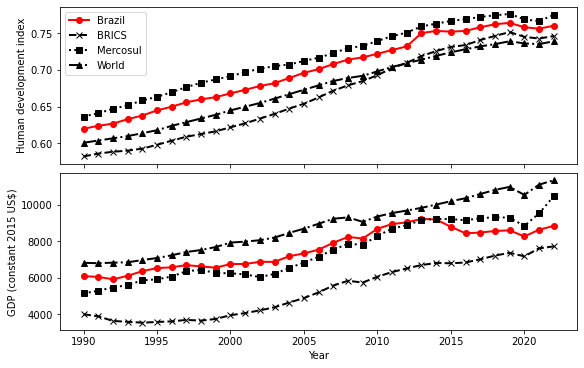

In [24]:
plt.close('all')
fig, [ax,ax2] = plt.subplots(2,1,sharex=True,constrained_layout=True, figsize=(8, 5))
ax.plot(hdr_df['Brazil'].index,hdr_df['Brazil'].values,label='Brazil')
ax.plot(hdr_df['BRICS'].index,hdr_df['BRICS'].values,label='BRICS')
ax.plot(hdr_df['Mercosul'].index,hdr_df['Mercosul'].values,label='Mercosul')
ax.plot(hdr_df['World'].index,hdr_df['World'].values,label='World')

ax.set_ylabel('Human development index')
ax.legend()

#ax2 = ax.twinx()

ax2.plot(gdp_capita_df['Brazil'].index,gdp_capita_df['Brazil'].values,label='Brazil')
ax2.plot(gdp_capita_df['BRICS'].index,gdp_capita_df['BRICS'].values,label='BRICS')
ax2.plot(gdp_capita_df['Mercosul'].index,gdp_capita_df['Mercosul'].values,label='Mercosul')
ax2.plot(gdp_capita_df['World'].index,gdp_capita_df['World'].values,label='World')

ax2.set_ylabel('GDP (constant 2015 US$)')

ax2.set_xlabel('Year')


# Correlation values

In [25]:
import scipy.stats

values = ['Brazil','BRICS','World','Mercosul']

for value in values:
    print(f"R-value for {value}: {scipy.stats.spearmanr(hdr_df[value].values, gdp_capita_df[value].values).correlation}")

R-value for Brazil: 0.9028915386018304
R-value for BRICS: 0.9605614973262033
R-value for World: 0.9954872276772494
R-value for Mercosul: 0.9632352941176471
